# Week 8 Assignment

# House Prices Advanced Regression Techniques competition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Load the datasets
train = pd.read_csv('Data/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('Data/house-prices-advanced-regression-techniques/test.csv')


In [2]:
# Remove 'Id' column and store it for later use in submission
train_id = train['Id']
test_id = test['Id']
train.drop(columns='Id', inplace=True)
test.drop(columns='Id', inplace=True)


In [3]:
# Handling missing values
for col in train.columns:
    if train[col].dtype == 'object':
        train[col] = train[col].fillna(train[col].mode()[0])
        test[col] = test[col].fillna(test[col].mode()[0])
    else:
        train[col] = train[col].fillna(train[col].median())
        if col in test.columns:  # Check if the column exists in the test dataset
            test[col] = test[col].fillna(test[col].median())


In [4]:
# Display basic info and summary stats
print(train.info())
print(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

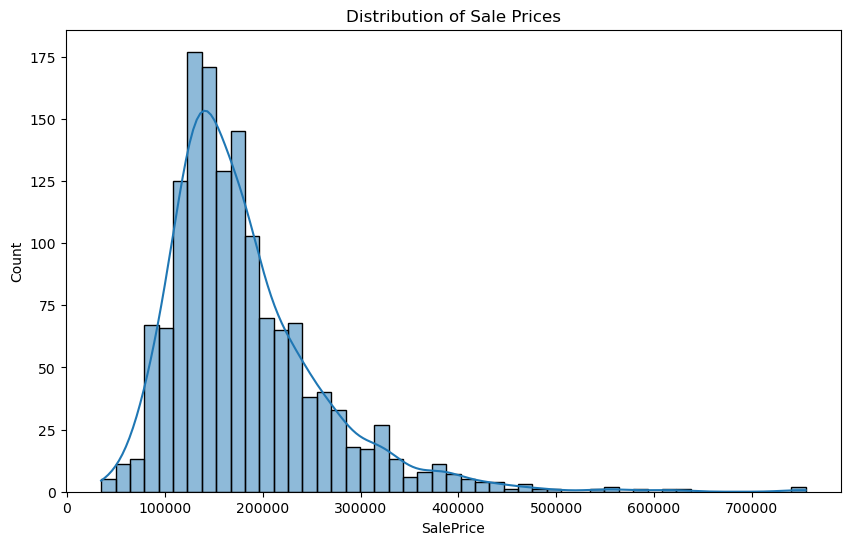

In [5]:
# Plotting distributions of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(train['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')
plt.show()

In [7]:
# Separate the target variable 'SalePrice' from the train dataset
y = train['SalePrice']
train.drop(columns='SalePrice', inplace=True)

# Convert categorical variables into dummy variables
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

# Align train and test datasets to have the same features
train, test = train.align(test, join='left', axis=1, fill_value=0)

# Identify numeric columns for polynomial features
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
train_poly = poly.fit_transform(train[numeric_cols])
test_poly = poly.transform(test[numeric_cols])

In [8]:

# Create DataFrame from polynomial features
train_poly_df = pd.DataFrame(train_poly, columns=poly.get_feature_names_out(input_features=numeric_cols))
test_poly_df = pd.DataFrame(test_poly, columns=poly.get_feature_names_out(input_features=numeric_cols))

# Concatenate polynomial features back to the main DataFrame
train = pd.concat([train.drop(columns=numeric_cols), train_poly_df], axis=1)
test = pd.concat([test.drop(columns=numeric_cols), test_poly_df], axis=1)

# Scale and reduce dimensionality
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)

# Train regression models
X_train, X_val, y_train, y_val = train_test_split(train_pca, y, test_size=0.2, random_state=42)
lr = LinearRegression().fit(X_train, y_train)
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3).fit(X_train, y_train)

# Predict and evaluate models
y_pred_lr = lr.predict(X_val)
y_pred_gbr = gbr.predict(X_val)
print(f'Linear Regression MSE: {mean_squared_error(y_val, y_pred_lr)}')
print(f'Gradient Boosting MSE: {mean_squared_error(y_val, y_pred_gbr)}')

# Prepare for submission
test_predictions_lr = lr.predict(test_pca)
test_predictions_gbr = gbr.predict(test_pca)

submission_lr = pd.DataFrame({'Id': test_id, 'SalePrice': test_predictions_lr})
submission_gbr = pd.DataFrame({'Id': test_id, 'SalePrice': test_predictions_gbr})
submission_lr.to_csv('submission_linear_regression.csv', index=False)
submission_gbr.to_csv('submission_gradient_boosting.csv', index=False)

print("Submission files prepared and saved.")

Linear Regression MSE: 1396939390.2440808
Gradient Boosting MSE: 1134954290.4210782
Submission files prepared and saved.


In [10]:
 #Interpret Linear Regression Coefficients
lr_coefficients = pd.DataFrame({
    'Feature': pca.get_feature_names_out(),
    'Coefficients': lr.coef_
})
print("Linear Regression Coefficients:")
print(lr_coefficients.sort_values(by='Coefficients', ascending=False))

Linear Regression Coefficients:
    Feature  Coefficients
0      pca0   5883.279998
32    pca32   4836.860736
163  pca163   4784.203414
110  pca110   4503.060977
68    pca68   3800.566690
..      ...           ...
28    pca28  -3142.965123
78    pca78  -3145.314122
70    pca70  -3735.069403
29    pca29  -3802.918573
127  pca127  -3816.877017

[190 rows x 2 columns]


In [11]:
# Feature Importance from Gradient Boosting
feature_importance_gbr = pd.DataFrame({
    'Feature': pca.get_feature_names_out(),
    'Importance': gbr.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Gradient Boosting Regressor Feature Importances:")
print(feature_importance_gbr)


Gradient Boosting Regressor Feature Importances:
    Feature  Importance
0      pca0    0.791141
21    pca21    0.024332
25    pca25    0.017475
2      pca2    0.015529
12    pca12    0.015466
..      ...         ...
73    pca73    0.000000
123  pca123    0.000000
162  pca162    0.000000
164  pca164    0.000000
71    pca71    0.000000

[190 rows x 2 columns]


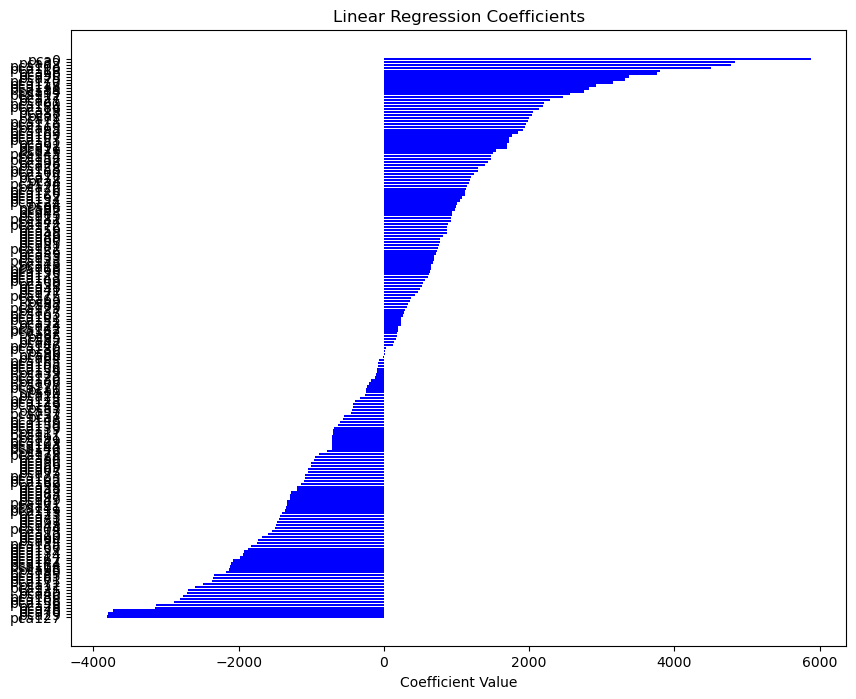

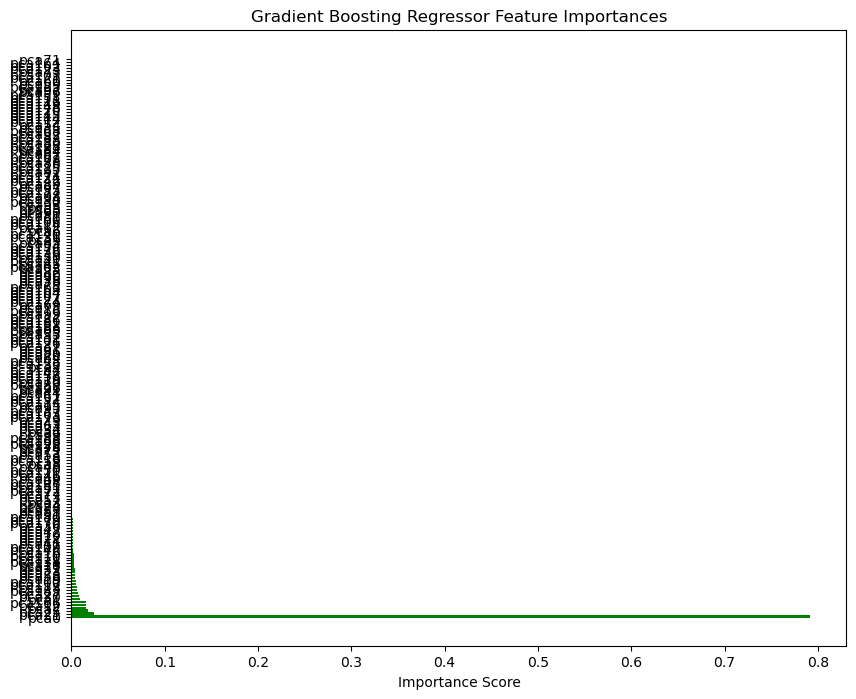

In [12]:
import matplotlib.pyplot as plt

# Plotting Linear Regression Coefficients
lr_coefficients_sorted = lr_coefficients.sort_values(by='Coefficients', ascending=True)
plt.figure(figsize=(10, 8))
plt.barh(lr_coefficients_sorted['Feature'], lr_coefficients_sorted['Coefficients'], color='blue')
plt.xlabel('Coefficient Value')
plt.title('Linear Regression Coefficients')
plt.show()

# Plotting Feature Importance for Gradient Boosting
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_gbr['Feature'], feature_importance_gbr['Importance'], color='green')
plt.xlabel('Importance Score')
plt.title('Gradient Boosting Regressor Feature Importances')
plt.show()


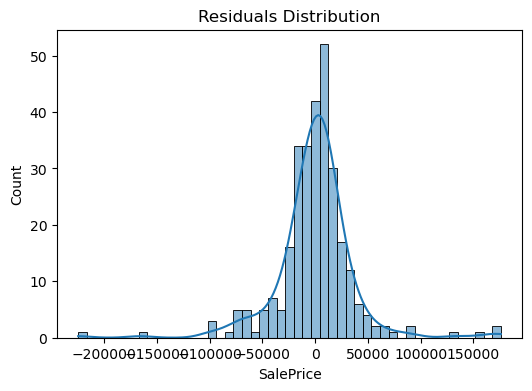

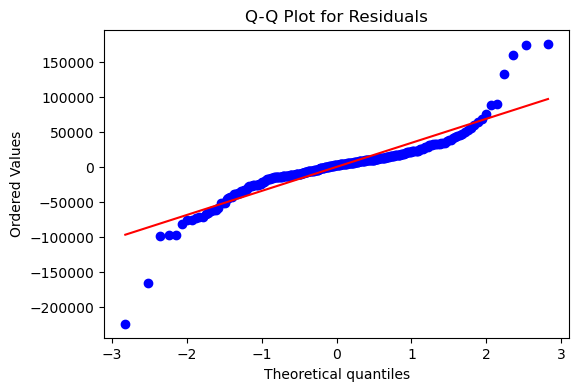

R-squared for Linear Regression: 0.8178774471240684


In [13]:
from scipy.stats import probplot

# Residuals plot
residuals_lr = y_val - lr.predict(X_val)
plt.figure(figsize=(6, 4))
sns.histplot(residuals_lr, kde=True)
plt.title('Residuals Distribution')
plt.show()

# Q-Q plot for normality check
plt.figure(figsize=(6, 4))
probplot(residuals_lr, dist="norm", plot=plt)
plt.title('Q-Q Plot for Residuals')
plt.show()

# Checking R-squared value
print("R-squared for Linear Regression:", lr.score(X_val, y_val))
